Comparisons of locomotion predictions of different mechanistic latent variable models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_plot

# Basic comparison of linear vs dynamical-adapting single vs population fits.

In [2]:
KBEHAVS = ['FFV', 'FLS']

rslts = {kbehav: [] for kbehav in KBEHAVS}

# purely linear fits
for kbehav in KBEHAVS:
    fit_data = np.load(f'data/simple/mlv/lin_filter/rc_lin_{kbehav.lower()}_276_tr.npy', allow_pickle=True)[0]
    nsplit = len(fit_data['r2_test'])
    
    key = 'Lin. filt. (r-cos.)'
    r2 = fit_data['r2_test'].mean()
    err = fit_data['r2_test'].std()/np.sqrt(nsplit)
    
    rslts[kbehav].append((key, r2, err))
    
    fit_data = np.load(f'data/simple/mlv/lin_filter/rect_lin_{kbehav.lower()}_276_tr.npy', allow_pickle=True)[0]
    nsplit = len(fit_data['r2_test'])
    
    key = 'Lin. filt (rect)'
    r2 = fit_data['r2_test'].mean()
    err = fit_data['r2_test'].std()/np.sqrt(nsplit)
    
    rslts[kbehav].append((key, r2, err))

In [3]:
labels = {'lin': 'Lin.', 'ln': 'LN', 'dyn': 'NLA'}
for nrl_mdl in ['lin', 'ln', 'dyn']:
    # load single ROI results
    for kbehav in KBEHAVS:
        fit_data = np.load(f'data/simple/mlv/neur_basic/baker_single_{nrl_mdl}_{kbehav.lower()}_276_tr.npy', allow_pickle=True)[0]
        nsplit, nr = fit_data['r2s_test'].shape
        
        # median single variance explained
        key = f'{labels[nrl_mdl]} neur (avg)'
        
        idx_med = np.argsort(fit_data['r2s_test'].mean(axis=0))[nr//2]  # arg-median
        r2 = fit_data['r2s_test'][:, idx_med].mean()
        err = fit_data['r2s_test'][:, idx_med].std()/np.sqrt(nsplit)
        
        rslts[kbehav].append((key, r2, err))
        
        # best single variance explained
        key = f'{labels[nrl_mdl]} neur (best)'
        
        idx_best = fit_data['r2s_test'].mean(axis=0).argmax()
        r2 = fit_data['r2s_test'][:, idx_best].mean()
        err = fit_data['r2s_test'][:, idx_best].std()/np.sqrt(nsplit)
        
        rslts[kbehav].append((key, r2, err))
        
    # load population ROI results
    for kbehav in KBEHAVS:
        fit_data = np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{kbehav.lower()}_276_tr.npy', allow_pickle=True)[0]
        
        key = f'{labels[nrl_mdl]} neur pop.'
        
        r2 = fit_data['r2_test'].mean()
        nsplit = len(fit_data['r2_test'])
        err = fit_data['r2_test'].std()/np.sqrt(nsplit)
        
        rslts[kbehav].append((key, r2, err))

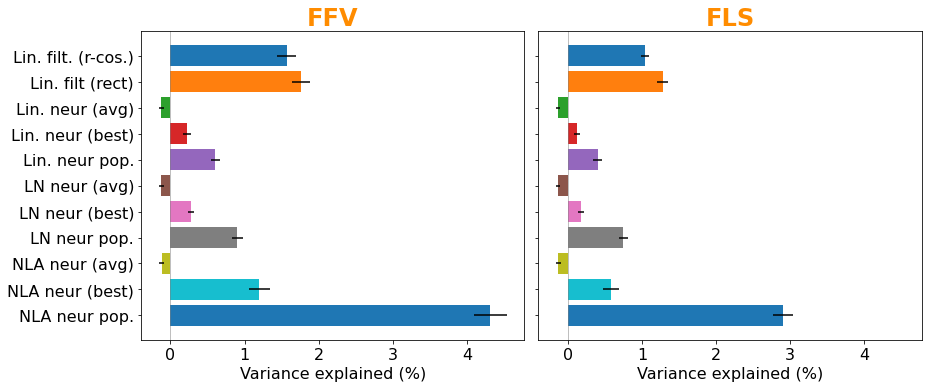

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(13, .5*len(rslts[KBEHAVS[0]])), tight_layout=True, sharex=True, sharey=True)
for kbehav, ax in zip(KBEHAVS, axs):
    for crslt, (key, r2, err) in enumerate(rslts[kbehav]):
        ax.barh([-crslt], [r2*100], xerr=[err*100])
        
    if ax == axs[0]:
        ax.set_yticks(-np.arange(len(rslts[kbehav])))
        ax.set_yticklabels([rslt[0] for rslt in rslts[kbehav]])
        
    ax.axvline(0, color='gray', lw=.5)
    set_plot(ax, x_label='Variance explained (%)', font_size=16)
    ax.set_title(kbehav, color='darkorange', fontweight='bold', fontsize=24)

## Predictions of "best" behavioral variable FFV_MN_60 (FFV with one-minute forward smoothing)
And using only NM91 and ZH23 strains

In [5]:
KBEHAVS = ['FFV_MN_60', 'FFV']

rslts = {kbehav: [] for kbehav in KBEHAVS}

# get prediction from timestamp only
fit_data = np.load(f'data/simple/mlv/neur_basic/nm91_zh23_{KBEHAVS[0].lower()}_from_time.npy', allow_pickle=True)[0]
for kbehav in KBEHAVS:
    r2 = fit_data['r2_test'][kbehav].mean()
    nsplit = len(fit_data['r2_test'][kbehav])
    err = fit_data['r2_test'][kbehav].std()/np.sqrt(nsplit)
    
    rslts[kbehav].append(('Timestamp', r2, err))

labels = {'lin': 'Lin.', 'ln': 'LN', 'dyn': 'NLA'}

for nrl_mdl in ['lin', 'ln', 'dyn']:
    # load single ROI results
    fit_data = np.load(f'data/simple/mlv/neur_basic/baker_single_{nrl_mdl}_nm91_zh23_{KBEHAVS[0].lower()}.npy', allow_pickle=True)[0]
    for kbehav in KBEHAVS:
        nsplit, nr = fit_data['r2s_test'][kbehav].shape
        
        # median single variance explained
        key = f'{labels[nrl_mdl]} neur (avg)'
        
        idx_med = np.argsort(fit_data['r2s_test'][kbehav].mean(axis=0))[nr//2]  # arg-median
        r2 = fit_data['r2s_test'][kbehav][:, idx_med].mean()
        err = fit_data['r2s_test'][kbehav][:, idx_med].std()/np.sqrt(nsplit)
        
        rslts[kbehav].append((key, r2, err))
        
        # best single variance explained
        key = f'{labels[nrl_mdl]} neur (best)'
        
        idx_best = fit_data['r2s_test'][kbehav].mean(axis=0).argmax()
        r2 = fit_data['r2s_test'][kbehav][:, idx_best].mean()
        err = fit_data['r2s_test'][kbehav][:, idx_best].std()/np.sqrt(nsplit)
        
        rslts[kbehav].append((key, r2, err))
        
    # load population ROI results
    fit_data = np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_nm91_zh23_{KBEHAVS[0].lower()}_ridge_alpha_10.npy', allow_pickle=True)[0]
    for kbehav in KBEHAVS:
        
        key = f'{labels[nrl_mdl]} neur pop.'
        
        r2 = fit_data['r2_test'][kbehav].mean()
        nsplit = len(fit_data['r2_test'][kbehav])
        err = fit_data['r2_test'][kbehav].std()/np.sqrt(nsplit)
        
        rslts[kbehav].append((key, r2, err))

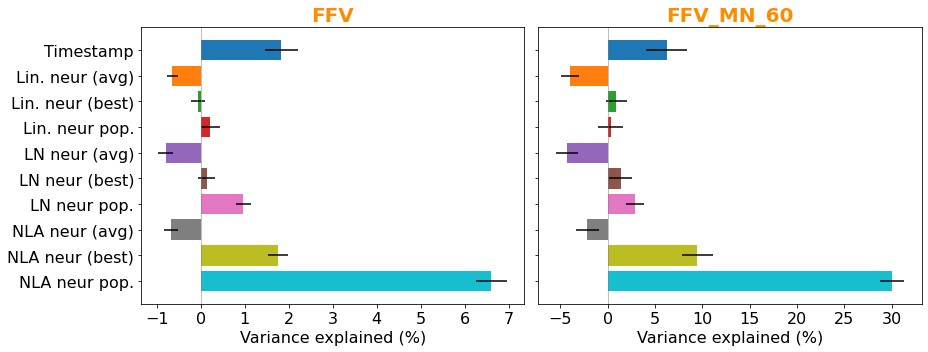

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(13, .5*len(rslts[KBEHAVS[0]])), tight_layout=True, sharey=True)
for kbehav, ax in zip(KBEHAVS[::-1], axs):
    for crslt, (key, r2, err) in enumerate(rslts[kbehav]):
        ax.barh([-crslt], [r2*100], xerr=[err*100])
        
    if ax == axs[0]:
        ax.set_yticks(-np.arange(len(rslts[kbehav])))
        ax.set_yticklabels([rslt[0] for rslt in rslts[kbehav]])
        
    ax.axvline(0, color='gray', lw=.5)
    set_plot(ax, x_label='Variance explained (%)', font_size=16)
    ax.set_title(kbehav, color='darkorange', fontweight='bold', fontsize=20)

# Neural activity projected onto top PCs

In [9]:
KBEHAVS = ['FFV', 'FLS']

rslts = {kbehav: [] for kbehav in KBEHAVS}

# load population ROI results
for npc in [3, 10, 224]:
    for kbehav in KBEHAVS:
        fit_data = np.load(f'data/simple/mlv/neur_basic/baker_dyn_pca_npc_{npc}_{kbehav.lower()}_276_tr.npy', allow_pickle=True)[0]

        key = f'NLA neurons\n{npc} PCs'

        r2 = fit_data['r2_test'].mean()
        nsplit = len(fit_data['r2_test'])
        err = fit_data['r2_test'].std()/np.sqrt(nsplit)

        rslts[kbehav].append((key, r2, err))

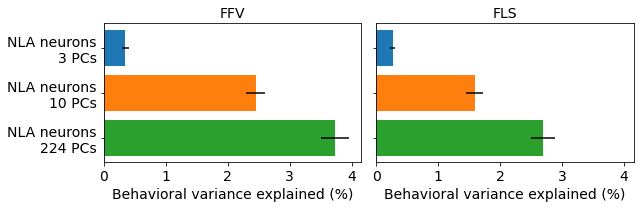

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, len(rslts[KBEHAVS[0]])), tight_layout=True, sharex=True, sharey=True)
for kbehav, ax in zip(KBEHAVS, axs):
    for crslt, (key, r2, err) in enumerate(rslts[kbehav]):
        ax.barh([-crslt], [r2*100], xerr=[err*100])
        
    if ax == axs[0]:
        ax.set_yticks(-np.arange(len(rslts[kbehav])))
        ax.set_yticklabels([rslt[0] for rslt in rslts[kbehav]])
        
    ax.axvline(0, color='gray', lw=.5)
    set_plot(ax, x_label='Behavioral variance explained (%)', title=kbehav, font_size=14)